# Python Implementation of _"Room Segmentation in 3D Point Clouds Using Anisotropic Potential Fields"_

### Author:
### Utku Turkbey     
* turkbey.utku@gmail.com
* [GitHub](https://github.com/uturkbey)
* [LinkedIn](https://www.linkedin.com/in/utku-turkbey-2213b018b/)

### ---------------------------------------------------------------------o---------------------------------------------------------------------
### About: 
This notebook includes the step by step Python implementation of the room segmentation pipeline proposed in the paper __"Room segmentation in 3D point clouds using anisotropic potential fields"__ by _D. Bobkov, M. Kiechle, S. Hilsenbeck, E. Steinbach_ presented at International Conference on Multimedia and Expo (ICME), Hong Kong, July 2017 [[1]](#ref). 

Purpose of this work is to provide a proof-of-concept Python implementation for the proposed room segmentation pipeline in [[1]](#ref). The code is not optimized for either computatational or space complexity. Some of the intermediate algorithms might be obtained partially or fully from other sources. Related references are provided when necessary. Same pipeline steps are fallowed as explained in the paper unless otherwise mentioned. The code is commented as much as possible to ease the work of a reader.  
### ---------------------------------------------------------------------o---------------------------------------------------------------------
### Abstract of the Paper: 
> "Emerging applications, such as indoor navigation or facility management, present new requirements of automatic and robust partitioning of indoor 3D point clouds into rooms. Previous research is either based on the Manhattan-world assumption or relies on the availability of the scanner pose information. We address these limitations by following the architectural definition of a room, where the room is an inner free space separated from other spaces through openings or partitions. For this we formulate an anisotropic potential field for 3D environments and illustrate how it can be used for room segmentation in the proposed segmentation pipeline. The experimental results confirm that our method outperforms state-of-the-art methods on a number of datasets including those that violate the Manhattan-world assumption." [[1]](#ref)

### ---------------------------------------------------------------------o---------------------------------------------------------------------
### For More Information About the Paper:
https://dbobkov.github.io/room-segmentation/
### ---------------------------------------------------------------------o---------------------------------------------------------------------
<a id='ref'></a>
### References:
[1] D. Bobkov, M. Kiechle, S. Hilsenbeck and E. Steinbach, "Room segmentation in 3D point clouds using anisotropic potential fields," 2017 IEEE International Conference on Multimedia and Expo (ICME), 2017, pp. 727-732, doi: 10.1109/ICME.2017.8019484. URL: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8019484&isnumber=8019290
        
[2] J. Straub, G. Rosman, O. Freifeld, J. J. Leonard and J. W. Fisher, "A Mixture of Manhattan Frames: Beyond the Manhattan World," 2014 IEEE Conference on Computer Vision and Pattern Recognition, 2014, pp. 3770-3777, doi: 10.1109/CVPR.2014.488. URL: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6909877&isnumber=6909393
    
[3] Y. Boykov and V. Kolmogorov, "An experimental comparison of min-cut/max- flow algorithms for energy minimization in vision," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 26, no. 9, pp. 1124-1137, Sept. 2004, doi: 10.1109/TPAMI.2004.60. URL: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1316848&isnumber=29188
    
[4] J. Jung, C. Stachniss, and C. Kim, “Automatic Room Segmentation of 3D Laser Data Using Morphological Processing,” ISPRS International Journal of Geo-Information, vol. 6, no. 7, p. 206, Jul. 2017, doi: 10.3390/ijgi6070206. URL: https://doi.org/10.3390/ijgi6070206

[5] Campello, R.J.G.B., Moulavi, D., Sander, J. (2013). Density-Based Clustering Based on Hierarchical Density Estimates. In: Pei, J., Tseng, V.S., Cao, L., Motoda, H., Xu, G. (eds) Advances in Knowledge Discovery and Data Mining. PAKDD 2013. Lecture Notes in Computer Science(), vol 7819. Springer, Berlin, Heidelberg. URL: https://doi.org/10.1007/978-3-642-37456-2_14

[6] Amanatides, John and Andrew Woo. “A Fast Voxel Traversal Algorithm for Ray Tracing.” Eurographics (1987). URL: https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.42.3443

[7] raytracer.cpp - 2004 - Jacco Bikker - jacco@bik5.com - www.bik5.com URL: https://www.flipcode.com/archives/raytracer4.zip

### ---------------------------------------------------------------------o---------------------------------------------------------------------
### Notebook Content:
1. [Pipeline Overview](#1)
2. [Preliminaries](#2)<br>
    2.1 [Imported Packages](#2.1)<br>
    2.2 [Helper Functions](#2.2)
3. [Input Data](#3)
4. [Interior Free Space Classification](#4) <br>
    4.1. [Free vs. Busy Space Classification](#4.1) <br>
    4.2. [Interior vs. Exterior Space Classification](#4.2) <br>
    4.3. [Alternative Interior vs. Exterior Space Classification](#4.3)
5. [Anisotropic Potential Field Computation](#5)
6. [Clustering](#6)
7. [Mapping of Free Space Labelling to Busy Space](#7)

### ---------------------------------------------------------------------o---------------------------------------------------------------------

<a id='1'></a>
### 1. Pipeline Overview

The proposed room segmentation pipeline is neatly visualized with the figure below provided in [[1]](#ref).

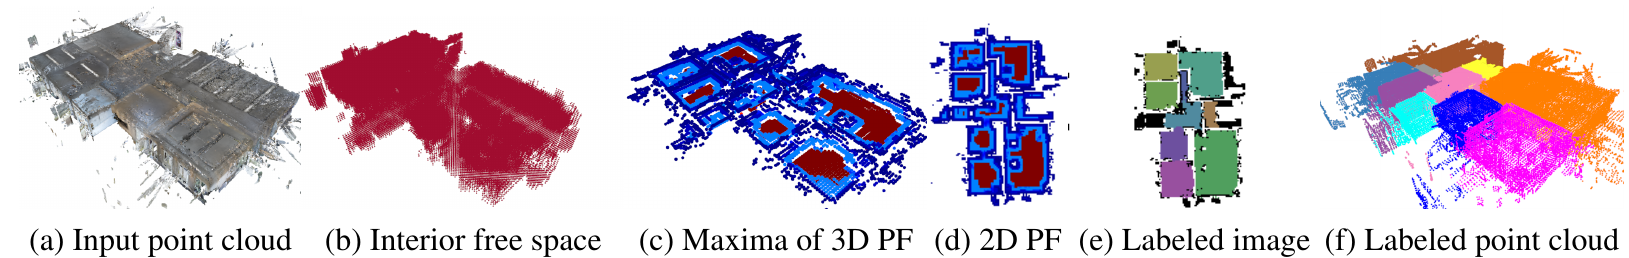

The authors of [[1]](#ref) summarize their pipeline with their own words as: 
> "We operate on a 3D point cloud (a) and start with detecting interior free space (b). We further proceed with computing a 3D anisotropic potential field (PF) for free voxels. Afterwards, we perform maxima detection in the PF values of each vertical voxel stack (c) and store the maximum value into a 2D PF map (d). Given the PF image, we perform clustering using information about the PF values as well as the visibility between voxels (e). Finally, we map the labeled free space back to the 3D point cloud (f)." [[1]](#ref)  

<a id='2'></a>
### 2. Preliminaries

Imported packages and helper fuctions for the implementation of the room segmentation pipeline.

<a id='2.1'></a>
### 2.1 Imported Packages

In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import copy
import hdbscan

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<a id='2.2'></a>
### 2.2 Helper Functions

#### _isVisible_ and _vec3d_
_isVisible_ function is used to check the visibility among the highest free voxels in every vertical stack and the _vec3d_ class provides the necessary vector representation and operations for visibility check. 

Visibility check is one of the core steps of the pipeline and also an important topic in both Computer Vision and Computer Graphics. The traversal algorithm used here to trace the ray direction from startin voxel to end voxel is based on the ___"A Fast Voxel Traversal Algorithm for Ray Tracing"___ [[6]](#ref) paper by _Amanitades and Woo_ and its implementation[[7]](#ref) in C++ by _Jacco Bikker_ provided at [_Ray Tracing Techniques_ section of _Flipcode Archives_](https://www.flipcode.com/archives/Raytracing_Topics_Techniques-Part_4_Spatial_Subdivisions.shtml).    

In [2]:
class vec3d:
    '''This class defines a vector and simple vector operations in 3D space.
       To be used in isVisible function.'''   
    def __init__(self, x=0, y=0, z=0):
        self.x = x
        self.y = y
        self.z = z
    
    def __sub__(self, other):
        return vec3d(self.x-other.x, self.y-other.y, self.z-other.z)
    
    def normalize(self):
        norm = ((self.x)**2 + (self.y)**2 + (self.z)**2)**0.5 
        self.x = self.x / norm
        self.y = self.y / norm
        self.z = self.z / norm
        
    def __str__(self):
        return f"<{self.x}, {self.y}, {self.z}>" 
    
def isVisible(voxels, start, end):
    '''Return 1 in case the end voxel is visible from the start voxel, and 0 otherwise.
    The other voxel is visible if there are no busy voxels in the ray direction starting 
    from the start voxel and terminating in the end voxel.'''
    

    '''voxels: int 3D _numpy.ndarray_ holding the classification information(dense) of the voxels.
          Interior Free Voxels -> 0
          Busy Voxels -> 1
          Exterior Free Voxels -> 2
       start: A tuple for the indices of the start voxel in (X,Y,Z) format.
       end: A tuple for the indices of the end voxel in (X,Y,Z) format.
        
       return: 1 if visible and 0 otherwise. For the base case, if start and end are same, return 1.'''
    
    if start == end:
        return 1
    
    #Initialize variables. 
    #Some variables are representing the same vectors and redundant yet for consistency with [7] they are used.
    start = vec3d(start[0],  start[1], start[2]) #convert to vector
    end = vec3d(end[0], end[1], end[2]) #convert to vector
    m_CW = 1 #sizes of a voxel
    curpos = start #starting point of ray
    raydir = end-start #direction vector of ray
    raydir.normalize()             
    e = vec3d(0,0,0) #starting position of the voxel grid
    stepX, stepY, stepZ = 0, 0, 0 #step sizes: either 1 or -1 depending on the ray direction
    outX, outY, outZ = 0, 0, 0 #limits for ray tracing
    cb = vec3d(0, 0, 0) #cell(voxel) boundary
    X, Y, Z = int(start.x), int(start.y), int(start.z) #indices of the current cell(voxel)
    tmax = vec3d(0,0,0) #the value of t at which the ray crosses the first v/h/. voxel boundary
    tdelta = vec3d(0,0,0) #how far along the ray we must move (in units of t) to travel the width of a voxel.
    
    #Determine step values and cell boundaries.
    if (raydir.x > 0):
        stepX = 1
        outX = end.x + 1
        cb.x = e.x + (X + 1) * m_CW
    else:
        stepX = -1
        outX = end.x - 1
        cb.x = e.x + X * m_CW
    if (raydir.y > 0):
        stepY = 1
        outY = end.y + 1
        cb.y = e.y + (Y + 1) * m_CW
    else:
        stepY = -1
        outY = end.y - 1
        cb.y = e.y + Y * m_CW
    if (raydir.z > 0):
        stepZ = 1
        outZ = end.z + 1
        cb.z = e.z + (Z + 1) * m_CW
    else:
        stepZ = -1
        outZ = end.z - 1
        cb.z = e.z + Z * m_CW
    
    #Determine the tmax and tdelta values.
    if (raydir.x != 0):
        tmax.x = (cb.x - curpos.x) / raydir.x 
        tdelta.x = (m_CW * stepX) / raydir.x
    else:
        tmax.x = 10000
    if (raydir.y != 0):
        tmax.y = (cb.y - curpos.y) / raydir.y 
        tdelta.y = (m_CW * stepY) / raydir.y
    else:
        tmax.y = 10000
    if (raydir.z != 0):
        tmax.z = (cb.z - curpos.z) / raydir.z 
        tdelta.z = (m_CW * stepZ) / raydir.z
    else:
        tmax.z = 10000
    
    #Trace the ray
    while (True):
        if (tmax.x < tmax.y):
            if (tmax.x < tmax.z):
                X = X + stepX
                if (X == outX):
                    return 0
                tmax.x += tdelta.x
            else:
                Z = Z + stepZ
                if (Z == outZ):
                    return 0
                tmax.z += tdelta.z
        else:
            if (tmax.y < tmax.z):
                Y = Y + stepY
                if (Y == outY):
                    return 0
                tmax.y += tdelta.y
            else:
                Z = Z + stepZ
                if (Z == outZ):
                    return 0
                tmax.z += tdelta.z
        if (voxels[X][Y][Z] == 1): #Ray passes through a busy voxel, end voxel is not visible.
            return 0
        if (X == end.x and Y == end.y and Z == end.z): #Visible if ray can be traced until
            return 1     

In [3]:
def getAxes():
    '''This functions returns a point cloud with color coded points representing 
    the X(Red), Y(Green), Z(Blue) axes and the Origin(Black).'''
    
    axes = o3d.geometry.PointCloud() #get an empty point cloud
    
    # manually define axes points (origin, x1, ..., x4, y1, ..., y4, z1, ... z4)
    np_points = np.zeros((13, 3))
    np_points[0] = [0,0,0]
    np_points[1] = [1,0,0] 
    np_points[2] = [2,0,0]
    np_points[3] = [3,0,0]
    np_points[4] = [4,0,0]
    np_points[5] = [0,1,0]
    np_points[6] = [0,2,0]
    np_points[7] = [0,3,0]
    np_points[8] = [0,4,0]
    np_points[9] = [0,0,1]
    np_points[10] = [0,0,2]
    np_points[11] = [0,0,3]
    np_points[12] = [0,0,4]

    #manually define axes colors (origin->black, X_axis->red, Y_axis->green, Z_axis->blue )
    np_colors = np.zeros((13, 3))
    np_colors[0] = [0,0,0];
    np_colors[1] = [1,0,0];
    np_colors[2] = [1,0,0];
    np_colors[3] = [1,0,0];
    np_colors[4] = [1,0,0];
    np_colors[5] = [0,1,0];
    np_colors[6] = [0,1,0];
    np_colors[7] = [0,1,0];
    np_colors[8] = [0,1,0];
    np_colors[9] = [0,0,1];
    np_colors[10] = [0,0,1];
    np_colors[11] = [0,0,1];
    np_colors[12] = [0,0,1];

    axes.points = o3d.utility.Vector3dVector(np_points)
    axes.colors = o3d.utility.Vector3dVector(np_colors)
    
    return axes

<a id='3'></a>
### 3. Input Data

-Input data is a 3D Point Cloud. Each point must have its position information encoded by a set of Cartesian coordinates (X, Y, Z). <br>
-No RGB/Intensity value or pose information is needed. <br>
-File format for the input data is assumed to be [Polygon File Format](http://paulbourke.net/dataformats/ply/)(_.ply_). It can be changed to any other suitable type . <br>

In [4]:
print(">>Load the input point cloud, calculate the bounding box, print and visualize(with axes). \n")
input_point_cloud = o3d.io.read_point_cloud(r".\multiRoom_input1.ply")
print(f"-Point cloud: {input_point_cloud}\n")
print(f"-Points in the cloud(X,Y,Z):\n{np.asarray(input_point_cloud.points)}\n")
aabb = input_point_cloud.get_axis_aligned_bounding_box()
aabb.color = [0,0,0]
print(f"-{aabb}")
axes = getAxes() #See 2.1 Helper Functions
#o3d.visualization.draw_geometries([input_point_cloud, aabb, axes])

>>Load the input point cloud, calculate the bounding box, print and visualize(with axes). 

-Point cloud: PointCloud with 339372 points.

-Points in the cloud(X,Y,Z):
[[ 4.94318962 -0.28139997  0.62947655]
 [ 7.40890169 -1.20943117  1.76394677]
 [-2.36834908 -1.34182632  2.68782687]
 ...
 [ 7.51455736  1.16042006  4.32707548]
 [ 3.06914258  0.41569203  2.48672366]
 [-2.76160002  0.84416002  1.93692887]]

-AxisAlignedBoundingBox: min: (-6.13429, -1.66451, -0.813977), max: (13.6245, 1.29454, 6.23765)


<a id='4'></a>
### 4. Interior Free Space Classification

-This block of the pipeline takes _input_point_cloud_ as the input. <br>
-(4.1)First, the space spanned by the bounding box of the point cloud is voxelized and the voxels are classified as free and busy. Isolated busy voxels are freed. <br>
-(4.2)(NOT IMPLEMENTED) Then, to identify the interior space, a simlified Markov Random Field formulation based on enclosing of the free voxels is proposed and solved using graphcuts.    
-(4.3)(ALTERNATIVE) Then, to identify the interior space, ceiling and floor are detected and they are used to defıne the interior space.

<a id='4.1'></a>
### 4.1. Free vs. Busy Space Classification

__Steps:__
* Voxelize the space spanned by the bounding box.
* Classify the voxels as busy of free.
* Free vertically enclosed busy voxels.

__Inputs:__
* _input_point_cloud_: 3D point cloud data
* (DIMINISHED - SEE v_size) v_ratio: User defined ratio parameter to determine the voxel size(v_size) based on the longest edge of the bounding box
* (REPLACED v_ratio) v_size: User defined voxel size parameter to be used for voxelizaion.

__Outputs:__
* _free_voxels_: int 3D _numpy.ndarray_: Free vs busy information of the voxels (dense). Free Voxels -> 0, Busy Voxels -> 1
* _voxel_grid_: Voxel grid created from the _input_point_cloud_

__General Comments:__
* -

__Comments on testing:__
* Algortihm below is tested with synthetic "axes" point cloud created by helper function _getAxes()_.
* Number of voxels calculated is checked. Built-in _o3d.geometry.VoxelGrid.create_from_point_cloud(...)_ starts partitioning the space by inserting a voxel centered at the minimum bound of the point cloud. Then continues by inserting full voxels until the upper bound and add an extra voxel if any space less then the voxel size is left. Therefore add 1 extra in each dimension to v_number=max_range/v_size.
* Created _free_voxels_ matrix is checked.
* _free_voxels_ matrix after freeing the isolated busy voxels is checked. Freeing mechanism works.
    
__Comments on efficiency:__
* Free check algorithm might be improved by: 
    * 1)Adding a mechanishm to skip the next 4 voxels in vertical stack since after freeing next 3 voxels will be free for sure.
    * 2)Rearranging the order of _if_ statements. (Not sure if a better order exists.)

In [5]:
#(DIMINISHED) #User defined ratio to determine voxel size
#(DIMINISHED) v_ratio = 0.009

#(DIMINISHED) #Determine the voxel size based on the longest edge of the bounding box and a constant ratio. Use 4 decimal point precision.
#(DIMINISHED) v_size=round(max(input_point_cloud.get_max_bound()-input_point_cloud.get_min_bound())*v_ratio, 4)  

v_size=0.18
v_number= (input_point_cloud.get_max_bound()-input_point_cloud.get_min_bound())/v_size
v_number[0], v_number[1], v_number[2] = round(v_number[0])+1, round(v_number[1])+1, round(v_number[2])+1 #+1 due to the calculation of voxel_grid
v_number = v_number.astype(int)

#Create a voxel grid with voxels for each subspace of the point cloud with at least one data point.   
voxel_grid=o3d.geometry.VoxelGrid.create_from_point_cloud(input_point_cloud,voxel_size=v_size)

#Transfer busy vs. free information from voxel grid to a 3D 'np.array'. 
free_voxels = np.zeros((v_number[0], v_number[1], v_number[2]), dtype=int) 
for voxel in voxel_grid.get_voxels():
    free_voxels[voxel.grid_index[0]][voxel.grid_index[1]][voxel.grid_index[2]] = 1 #Busy_Voxel->1 (Free_Voxel->0) 

#Free the isolated busy voxels (new version)
for plane in free_voxels: #get planes orthogonal to X-axis
    for vertical_stack in plane.T: #get vertical stacks parallel to Y-axis
        for y in range(v_number[1]):
            if vertical_stack[y] == 1: #if a voxel is busy
                if y < len(vertical_stack)-4 and vertical_stack[y+1] == 0 and vertical_stack[y+2] == 1 and vertical_stack[y+3] == 0 and vertical_stack[y+4] == 1:
                    vertical_stack[y+2] = 0; #free the isolated voxel

print(f"Number of busy voxels out of total number of voxels: {len(voxel_grid.get_voxels())}/{v_number[0]*v_number[1]*v_number[2]}")
#o3d.visualization.draw_geometries([voxel_grid, aabb, axes])

Number of busy voxels out of total number of voxels: 11673/75480


<a id='4.2'></a>

### 4.2. Interior vs. Exterior Space Classification
__Steps:__
* Apply _Mixture of Manhattan Frames Algorithm_ [[2]](#ref) to calculate the two dominant directions of free voxels to check enclosing.
* Calculate evidence _E(v)_ for each free voxel.
* Build a 6-neighorhood connected graph spanning all free voxels.
* Compute graphcut by using _Boykov-Kolmogorov Mincut Algorithm_ [[3]](#ref) to detect interior free voxels.

__Inputs:__

__Outputs:__

__General Comments:__
* To be implemented later.

__Comments on testing:__

__Comments on efficiency:__

In [6]:
#Apply Mixture of Manhattan Frames

#Calculate E(v)
    
#Build a connected graph
    
#Compute graphcut using Boykov-Kolmogorov Mincut Algorithm. 


<a id='4.3'></a>

### 4.3. Alternative Interior vs. Exterior Space Classification

An alternative to the current interior/exterior classification approach in [[1]](#ref) is preferred for implementaton simplicity. This alternative approach is inspired from another room segmentation approach in [[4]](#ref) and adapted to the current pipeline.

__Steps:__
* Compute a histogram over busy voxels along the Y-axis to see the height variations. Pick the heights of the two peaks in histogram to be the floor and ceiling heights.  
* Mark all the voxels below/above these heights and outside the region defined by the XZ projection of the ceiling and floor as exterior. (Including the busy voxels. This also denoises the data by removing outliers.) Remainnig pixels are assumed to be the interior free voxels.

__Inputs:__
* _free_voxels_: int 3D _numpy.ndarray_: Free vs busy information of the voxels(dense). Interior Free Voxels -> 0, Other Voxels -> 1 
* _voxel_grid_: Voxel grid created from the _input_point_cloud_ <br>

__Outputs:__
* _free_voxels_: int 3D _numpy.ndarray_: Information of the interior free voxels vs others (dense). <br> Interior Free Voxels -> 0, <br> Busy Voxels -> 1, <br>Exterior Free Voxels -> 2 <br>

__General Comments:__
* This algorithm does not perform well with every type of scan(e.g. curved ceilings). Needs to be improved!! Check the depth images approach. 

__Comments on testing:__
* Manually tested with simple input point cloud data. Works fine.

__Comments on efficiency:__
* Might be combined with voxel freeing in section 4.1 to obtain the same results with a single pass.

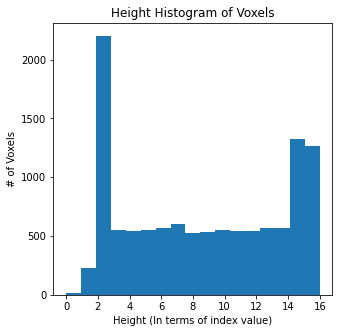

In [7]:
#Compute the histogram over busy voxels along the Y-axis
heights = [voxel.grid_index[1] for voxel in voxel_grid.get_voxels()]
plt.figure(figsize=(5, 5))
hist = plt.hist(heights, v_number[1])
plt.title("Height Histogram of Voxels")
plt.xlabel("Height (In terms of index value)")
plt.ylabel("# of Voxels")
plt.show()

#Select the two peak heights, min of them is floor height and max of them is ceiling height
peak_height1 = int(hist[1][np.argmax(hist[0])+1])
peak_height2 = int(hist[1][np.where(hist[0]==np.partition(hist[0], -2)[-2])][0])
floor = min(peak_height1, peak_height2)
ceiling = max(peak_height1, peak_height2)

#Detect exterior free voxels.
for plane in free_voxels: #get planes orthogonal to X-axis
    for vertical_stack in plane.T: #get vertical stacks parallel to Y-axis
        if vertical_stack[floor]==0 and vertical_stack[ceiling]==0: #if the voxels are not in the region defined by the projection of ceiling and floor
            for y in range(v_number[1]):
                    vertical_stack[y] = 2
        else: #if the voxels are below or above the ceiling heights
            for y in range(v_number[1]):
                if y < floor:
                    vertical_stack[y] = 2
                if y > ceiling:
                    vertical_stack[y] = 2           

<a id='5'></a>
### 5. Anisotropic Potential Field Computation

Explanation in the related section of [[1]](#ref) about which voxels should be considered for visiblity check might be misinterpretted. In this implementation, visiblity is computed among the highest free voxels of of each vertical stack in Y-direction.

__Steps:__
* For every free voxel, perform nearest neighbor search in the halfspace spanning the positive Y-direction. This way, every voxel stores the L2-distance to the closest busy voxel lying in the half-space spanning positive Y values, so called anisotropic potential field (PF) value. Record it to _pf_3D_.
* Project _pf_3D_ data to XZ-plane by choosing the maximum values over each vertical stack in Y-axes. Record it to _pf_2D_.
* (Simultaneously with the previous step) Detect highest free voxel of each vertical stack in Y-direction, record it to _highest_free_voxels_.
* (Optional) Plot 2D PF Map.
* Perform visibility checks between _highest_free_voxels_. Visibility result is 1 in case the other voxel is visible from this one, and 0 otherwise. The other voxel is visible if there are no busy voxels in the ray direction starting from the first voxel and terminating in the second voxel.
* After calculating the visibility vector for each highest free voxel, record taht vector to the _visib_map_.

__Inputs:__
* _free_voxels_: int 3D _numpy.ndarray_: Information of the interior free voxels vs others (dense). <br> Interior Free Voxels -> 0, <br> Busy Voxels -> 1, <br>Exterior Free Voxels -> 2 <br>
* _voxel_grid_: Voxel grid created from the _input_point_cloud_ <br>

__Outputs:__
* _pf_3D_: float 3D _numpy.ndarray_ (dense): PF value of each free interior voxel.
* _pf_2D_: float 2D _numpy.ndarray_ (dense): Maximum PF value in each vertical stack, i.e. a special projection of _pf_3D_.
* _highest_free_voxels_: 1D Python list: Indices(as tuples) of highest free voxels in each vertical stack.
* _visib_map_: 2D Python list(dense): Visibility vectors of highest interior free voxels of each vertical stack.

__General Comments:__
* -

__Comments on testing:__
* Manually tested with one single room and one multiple room input point cloud data. Outlier points which cannnot be filtered during the interior vs exterior classification is reflected on the PF maps as expected. PF distribuitons seems reasonable. 
* Visibility check is only tested at the level of isVisible function. isVisible works successfuly and considering the simplicity of the rest of the visibility check sections, it is highly likely that visibility check is successful in general.    

__Comments on efficiency:__
* Calculation of L2 norms from each pixel to every busy voxel in the above halfspace is computationally heavy compared to the rest of the pipeline. Needs improvement in the future. 
    * Calculating distances for all points in the same plane perpendicular to Y-axis and then choose the min distances for each free voxel might be a strategy. However memory requirements increases and computation load might not be decreased. 
    * Alternatively, KDTree might be used but building tree for each halfspace might be computationally heavy. 
* Visibility check is also heavy compared to the rest of the pipeline. Needs improvement in the fututre.
    * Python list is preferred to np.arrays for _visib_map_ since it can store both integers and other data structures at the same time. 
    * _visib_map_ location is preallocated, however _visib_vec_ are created by appending to an existing list which results in inefficiency. Preallocated np.arrays might be preferred however then indexing to loop over the _highest_free_voxels_ will be reqired as opposed to current looping by iteration.
    * Furthermore, size of visib_map is significantly large. (__Printing _visib_map_ might cause running out of memory and should be avoided.__)


In [8]:
pf_2D = np.zeros((v_number[0], v_number[2]))
pf_3D = np.zeros((v_number[0], v_number[1], v_number[2]))


#Find the L2(euclidian) norm of every free voxel to its nearest neighbor. Start from the free voxels lying in 
#the lowest(in terms of Y coords.) plane parallel to XZ-plane. Then continue with the other voxels in 
#upper planes(in terms of Y coord). By doing so, use the list of busy voxels in
#the halfspace spanning the positive Y-direction. 
i = 0 #to trace Y level
for plane in np.moveaxis(free_voxels, 0, 1): #Each plane is vertical to Y-axis
    #Select busy voxels in the halfspace spanning the positive Y-direction wrt. the Y level of current plane.
    busy_voxels = np.asarray([voxel.grid_index for voxel in voxel_grid.get_voxels() if voxel.grid_index[1]>=i])
    for x in range(v_number[0]):
        for z in range(v_number[2]):
            if plane[x][z] == 0: #calculate pf for only interior free voxels.
                pf_3D[x][i][z] = min(distance.cdist(busy_voxels, np.array([[x,i,z]]), 'euclidean'))[0]
    i = i + 1 #increase y to trace Y level of current planes             

    
#Project pf_3D to XZ-plane (Will result in a dense array with many zero PF valued voxels)
#Simultaneously, detect the maximum free voxels among each vertical stack with at least one interior free voxelç
highest_free_voxels = list()    
for x in range(v_number[0]):
    for z in range(v_number[2]):
        y_index_of_max = np.argmax(pf_3D[x].T[z]) #find index of maximum along a vertical stack
        maximum_pf = pf_3D[x][y_index_of_max][z] #project the maximum to XZ-plane
        pf_2D[x][z] = maximum_pf
        if (maximum_pf > 0): #if there is at least one free voxel at that stack than find the highest free voxel of the stack
            highest_y = -1
            for y in range(v_number[1]):
                if free_voxels[x][y][z] == 0:
                    highest_y = y
            if highest_y > -1:
                highest_free_voxels.append((x,y,z))

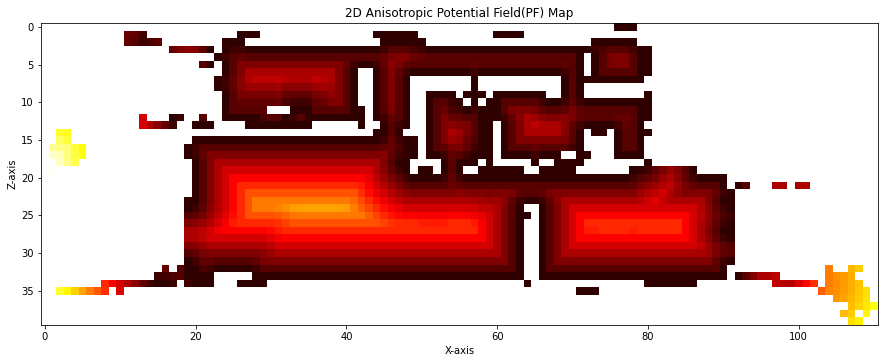

In [9]:
#Plot the 2D PF Map (only for the free voxels with PF values)
cmap = copy.copy(plt.get_cmap('hot'))
cmap.set_under('white')
plt.figure(figsize=(15, 15))
plt.imshow(pf_2D.T, cmap=cmap, vmin=0.1)
plt.title("2D Anisotropic Potential Field(PF) Map")
plt.xlabel("X-axis")
plt.ylabel("Z-axis")
plt.show()

In [10]:
#Create an empty visib_map list with the shape of pf_2D
x = v_number[0]
z = v_number[2]
visib_map = [0] * x
for i in range(x):
    visib_map[i] = [0] * z
    
#Calculate the visiblity vectors for each highest free voxel and record it to visib_map
for start in highest_free_voxels:
    visib_vec = list()
    for end in highest_free_voxels:
        visib_vec.append(isVisible(free_voxels, start, end))
    visib_map[start[0]][start[2]] = visib_vec

<a id='6'></a>
### 6. Clustering

Due to the obscurred explanation for thresholding in the related section of [[1]](#ref), currently implemented thresholding approach might and highly likely to be varied from the actual pipeline. For the details of thresholding approach see __additional notes__.

Additional denoising step is introduced indepently from the [[1]](#ref)  

[HDBSCAN Library](https://hdbscan.readthedocs.io/en/latest/index.html) implemented based on [[5]](#ref) is used for clustering purposes. 

__Steps:__
* (Optional) Denoise the 2D PF Map by first clustering with HDBSCAN solely based on Euclidian distance. 
    * Define the weights to be used for Difference Matrix calculation.
    * Obtain the sparse represantation of (free interior) voxels.
    * Calculate the Difference Matrix D for every voxel.
    * Cluster with HDBSCAN and use the label with largest number of voxels as the Denoising Mask and filter the original 2D PF Map with this mask.
    * (Optional) Plot the Denoising Mask and Denoised PF Map.

* Define the weights to be used for Difference Matrix calculation.
* Obtain the sparse represantation of (free interior) voxels and apply a threshold in terms of PF values to aid clustering by obtaining global maximums.
* Calculate the Difference Matrix D for every thresholded voxel.
* Apply HDBSCAN algorithm to cluster rooms.
* Obtain the dense map of voxels from large clusters(>10 voxels).
* (Optional) Plot the clustered voxels.
* (NOT IMPLEMENTED) Apply region growing to cluster the voxels omitted either during thresholding or HDBSCAN applicaiton.

__Inputs:__
* _pf_2D_: float 2D _numpy.ndarray_ (dense): Maximum PF value in each vertical stack, i.e. a special projection of _pf_3D_.
* _visib_map_: 2D Python list(dense): Visibility vectors of highest interior free voxels of each vertical stack.

__Outputs:__
* _clustered_: int 2D _numpy.ndarray_ (dense): Clustered voxels. 

__General Comments:__
* Denoising mechanishm might be useless. Requires more testing.
* Clustering does not segment rooms with every test data. __Methodology is not generelizeable.__

__Comments on testing:__
* Tested with whole test data. Methodology is not generealizeable. Most of the results are not successfull.

__Comments on efficiency:__
* Creating a an empty list named _voxels_ to store free voxels and appending it every time might be inefficient. Improvement might be usefull.
* Hamming distance calculations increase the run time drastically.

__Additional notes on the preferred thresholding approach:__

After obtaining the denoised PF Map from an arbitrary multiroom point cloud, if we look at the distribution of PF values, we see the histogram with 30 bins in the Figure below. Which does not provide an obvious insight about how to pick a suitable threshold. “To derive a threshold, we build a histogram of intensity values and detect the density peak with largest value.” words in the paper cannot be mapped to such any histogram despite the efforts of experimenting with various bin parameters.

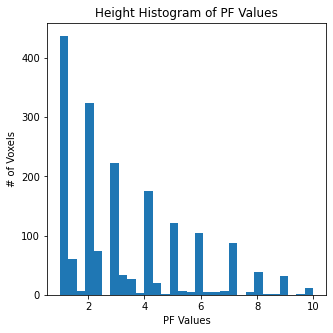

However, if we look at the rounded distinct values listed below that PF obtains, we might come up with a heuristic threshold.

[1.0, 1.41, 1.73, 2.0, 2.24, 2.45, 2.83, 3.0, 3.16, 3.32, 3.46, 3.61, 3.74, 4.0, 4.12, 4.24, 4.36, 4.47, 4.58, 4.9, 5.0, 5.1, 5.39, 5.48, 5.66, 5.74, 5.83, 5.92, 6.0, 6.08, 6.32, 6.4, 6.63, 6.71, 6.78, 7.0, 7.07, 7.21, 7.28, 7.62, 7.81, 8.0, 8.06, 8.49, 8.6, 8.94, 9.0, 9.43, 10.0]

Intuitively, by the definition of PF as the Euclidian distance of a free voxel to its nearest busy voxel, it makes sense to see such values. Square of 1 is 1 and this value is obtained by the free voxels which share one face with their nearest busy voxel neighbors. Next value 1.41, which is square root of 2, comes from the free voxels which share one edge with their nearest busy voxel neighbors. And for 1.73(square root of 3), this value which share one corner with their nearest busy voxel neighbors. If we also consider that above listed values are the projection of 3D PF to 2D by picking the maximum PF values in Y-axis aligned vertical stacks, then we might say that those 3 values (1.0, 1.41, 1.73) might be only coming from the vertical stacks that are on the borders of our walls. Hence 1) they will always appear in our PF list and 2)Removing them means, in a sense, peeling one layer more from the interior free space. Although, peeling one more layer does not guarantee removing the links between rooms it might still offer practical advantages while running HDBSCAN once again over the denoised PF Map. Therefore, defining a threshold of 1.75 seemed worth giving a try.

In [11]:
                                        #DENOISING (Optional)
#Weights of distances
w_eucl = 1

#Get the voxels (in sparse representation) to be clustered
#(From dense array with many zero PF valued voxels to a list of actual voxels representing imterior free space)
voxels = list()
for x in range(pf_2D.shape[0]):
    for z in range(pf_2D.shape[1]):
        if pf_2D[x][z] >= 0.1:
            voxels.append((x,z))        

#Define difference matrix D
D = np.zeros((len(voxels),len(voxels)))

#Calculate difference matrix D (Actually only do calculation for the upper triangle part and use symmetry)           
for i in range(len(voxels)):
    for j in range(i, len(voxels)):
        x_i = voxels[i][0]
        z_i = voxels[i][1] 
        x_j = voxels[j][0]
        z_j = voxels[j][1]
        D[i][j] = (((x_i-x_j)**2 + (z_i-z_j)**2 )**0.5)*w_eucl
D = D + D.T #Define lower triangle as the symetric of the upper triangle

#Cluster voxels using HDBSCAN module
clusterer = hdbscan.HDBSCAN(metric='precomputed')
clusterer.fit(D)

#Define a denoising mask
denoising_mask = np.zeros((v_number[0], v_number[2]))
denoising_mask = denoising_mask.astype(int)
if min(clusterer.labels_) == -1:
    largest_cluster_label = np.bincount(clusterer.labels_ + 1).argmax() - 1
else:
    largest_cluster_label = np.bincount(clusterer.labels_).argmax()
for index in range(len(voxels)):
    if clusterer.labels_[index] == largest_cluster_label:
        denoising_mask[voxels[index][0]][voxels[index][1]] = 1

#Denois 2D PF Map using the denoising mask 
pf_2D_denoised = pf_2D * denoising_mask

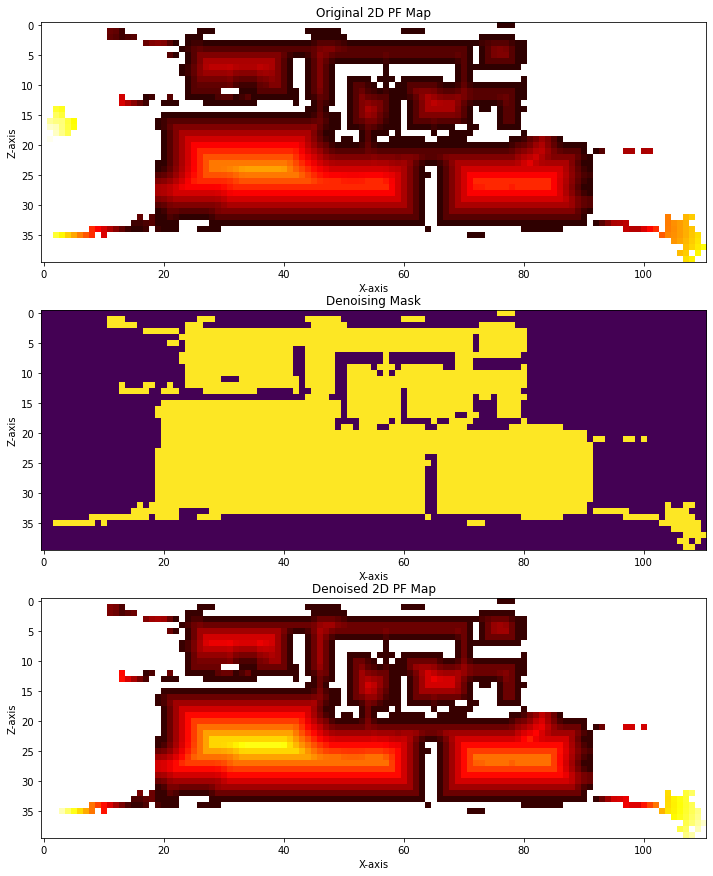

In [12]:
#Plot the denoising mask and denoised PF Map
plt.figure(figsize=(20, 15))

plt.subplot(311)
plt.imshow(pf_2D.T, cmap=cmap, vmin=0.1)
plt.title("Original 2D PF Map")
plt.xlabel("X-axis")
plt.ylabel("Z-axis")

plt.subplot(312)
plt.imshow(denoising_mask.T)
plt.title("Denoising Mask")
plt.xlabel("X-axis")
plt.ylabel("Z-axis")

plt.subplot(313)
plt.imshow(pf_2D_denoised.T, cmap=cmap, vmin=0.1)
plt.title("Denoised 2D PF Map")
plt.xlabel("X-axis")
plt.ylabel("Z-axis")

plt.show()

In [13]:
                                        #ROOM CLUSTERING
#Weights of distances
w_eucl = 0.6
w_vis = 0 #w_vis = 0.3
w_pf = 0 #w_pf = 0.1
threshold = 1.75

#Get the voxels to be clustered
#(From dense array with many zero PF valued voxels to a list of actual voxels representing imterior free space)
voxels = list()
for x in range(pf_2D_denoised.shape[0]):
    for z in range(pf_2D_denoised.shape[1]):
        if pf_2D_denoised[x][z] >= threshold:
            voxels.append((x,z,pf_2D_denoised[x][z]))        

#Define difference matrix D
D = np.zeros((len(voxels),len(voxels)))

#Calculate difference matrix D (Actually only do calculation for the upper triangle part and use symmetry)           
for i in range(len(voxels)):
    for j in range(i, len(voxels)):
        x_i = voxels[i][0]
        z_i = voxels[i][1] 
        x_j = voxels[j][0]
        z_j = voxels[j][1]
        D[i][j] = (((x_i-x_j)**2 + (z_i-z_j)**2 )**0.5)*w_eucl + abs(voxels[i][2]-voxels[j][2])*w_pf + distance.hamming(visib_map[x_i][z_i], visib_map[x_j][z_j])*w_vis
D = D + D.T #Define lower triangle as the symetric of the upper triangle

#Cluster voxels using HDBSCAN module
clusterer = hdbscan.HDBSCAN(metric='precomputed')
clusterer.fit(D)

#Obtain distşnct labels after clustering and their counts
distinct_labels = list()
for val in [label for label in clusterer.labels_]:
    if val not in distinct_labels:
        distinct_labels.append(val)
distinct_labels.sort() 
label_counts = np.bincount(clusterer.labels_ + 1)

#print("Distinct Cluster Labels")
#print(distinct_labels)
#print()
#print("Cluster Label Counts")
#print(label_counts)

#Obtain the dense map of voxels from large clusters(>10 voxels).
clustered = np.zeros((v_number[0], v_number[2]))
clustered = clustered.astype(int)
small_clusters = (np.asarray(distinct_labels)+3)*(label_counts<10)-3
for index in range(len(voxels)):
    if clusterer.labels_[index] not in small_clusters:
        clustered[voxels[index][0]][voxels[index][1]] = clusterer.labels_[index]+1

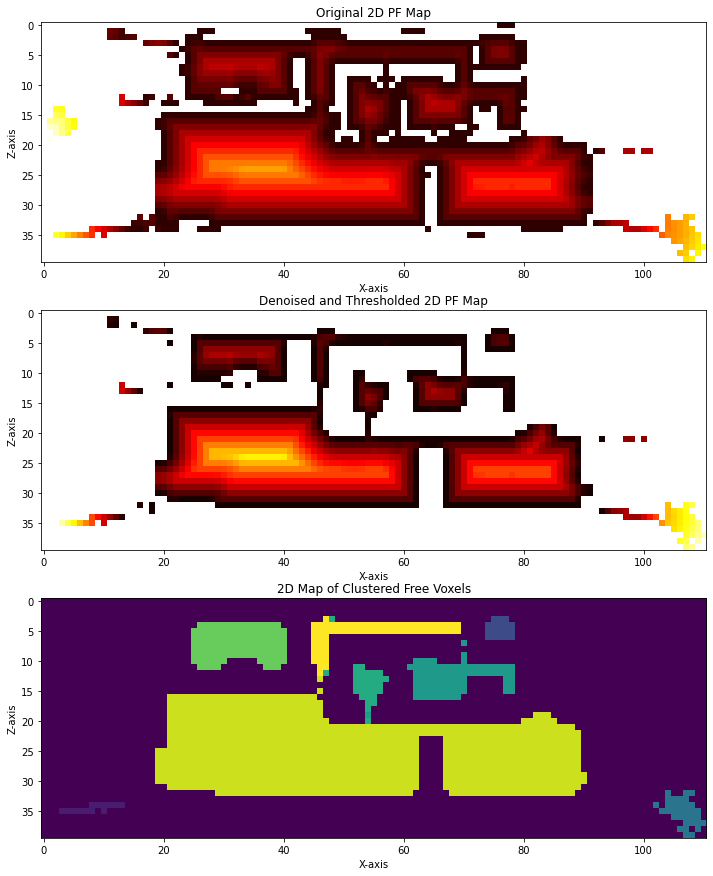

In [14]:
#Plot the 2D map of clustered free voxels.
plt.figure(figsize=(20, 15))

plt.subplot(311)
plt.imshow(pf_2D.T, cmap=cmap, vmin=0.1)
plt.title("Original 2D PF Map")
plt.xlabel("X-axis")
plt.ylabel("Z-axis")

plt.subplot(312)
plt.imshow(pf_2D_denoised.T, cmap=cmap, vmin=threshold)
plt.title("Denoised and Thresholded 2D PF Map")
plt.xlabel("X-axis")
plt.ylabel("Z-axis")

plt.subplot(313)
plt.imshow(clustered.T)
plt.title("2D Map of Clustered Free Voxels")
plt.xlabel("X-axis")
plt.ylabel("Z-axis")

plt.show()

<a id='7'></a>
### 7. Mapping of Free Space Labelling to Busy Space